### Magics

In [68]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

%load_ext watermark
%watermark -a 'Salomon Tetelepta' -d -t -v -p tensorflow,numpy,pandas,matplotlib -g

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Salomon Tetelepta 2019-09-14 13:15:34 

CPython 3.7.4
IPython 7.7.0

tensorflow 1.14.0
numpy 1.16.4
pandas 0.25.0
matplotlib 3.1.1
Git hash: 5949f436287087825c47d8cc576b79166e2863ff


### Imports

In [69]:
import os
import sys

import numpy as np
import pandas as pd
import cv2

import pickle

from pathlib import Path

# tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.compat.v1.keras.models import load_model
from tensorflow.keras.metrics import categorical_accuracy

# import DCNN model
from tensorflow.keras.applications import ResNet50

# import preprocessing functions for model
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50


### Settings

In [70]:
# get project path, and flag if script runs in a file
project_path = Path(os.getcwd(), os.pardir)
output_path = project_path / "output"
model_path = project_path / "models"

# add project root to pythonpath
sys.path.insert(0, str(project_path / "src"))

# import custom packages
from set_cardgame.dataset import *
from set_cardgame.identify import *   
from set_cardgame.utils import *
from set_cardgame.findsets import *

### Load models

In [72]:
# load intermediate DCNN (ResNet50), outputs at best performing layer (stage 3, blockd, first conv layer)
dcnn_model_name = "resnet50-res3d_branch2a.h5"
intermediate_model = load_model(
    model_path / dcnn_model_name,
    custom_objects=None, 
    compile=True
)

# load linear classifier, trained with 8100 images
linear_classifier_model_name = "clf-lr-res3d_branch2a_8100.pkl"
with open(model_path / linear_classifier_model_name, 'rb') as handle:
    best_model = pickle.load(handle)

### Detect SET combinations

===
processing: IMG_7802.JPG
number of cards found: 12
nr sets found: 3
SET 1/3
- purple round dotted one
- purple squiggle open two
- purple square solid three
SET 2/3
- green squiggle solid two
- red round solid one
- purple square solid three
SET 3/3
- green squiggle dotted one
- red squiggle solid three
- purple squiggle open two


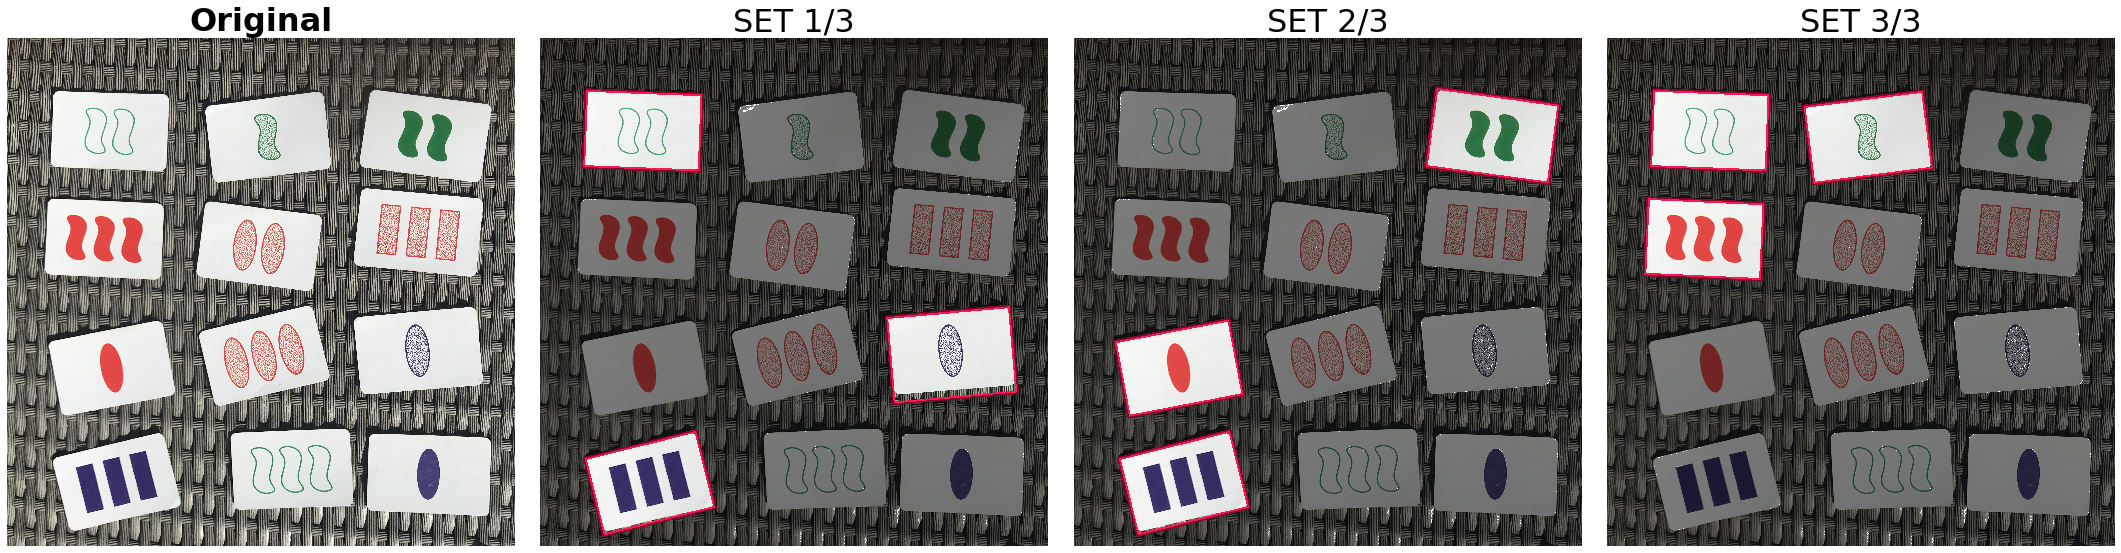

===
processing: IMG_6138.JPG
number of cards found: 12
nr sets found: 3
SET 1/3
- green square dotted two
- purple square dotted three
- red square dotted one
SET 2/3
- purple square dotted three
- purple square solid three
- purple square open three
SET 3/3
- red square dotted one
- red square dotted three
- red square dotted two


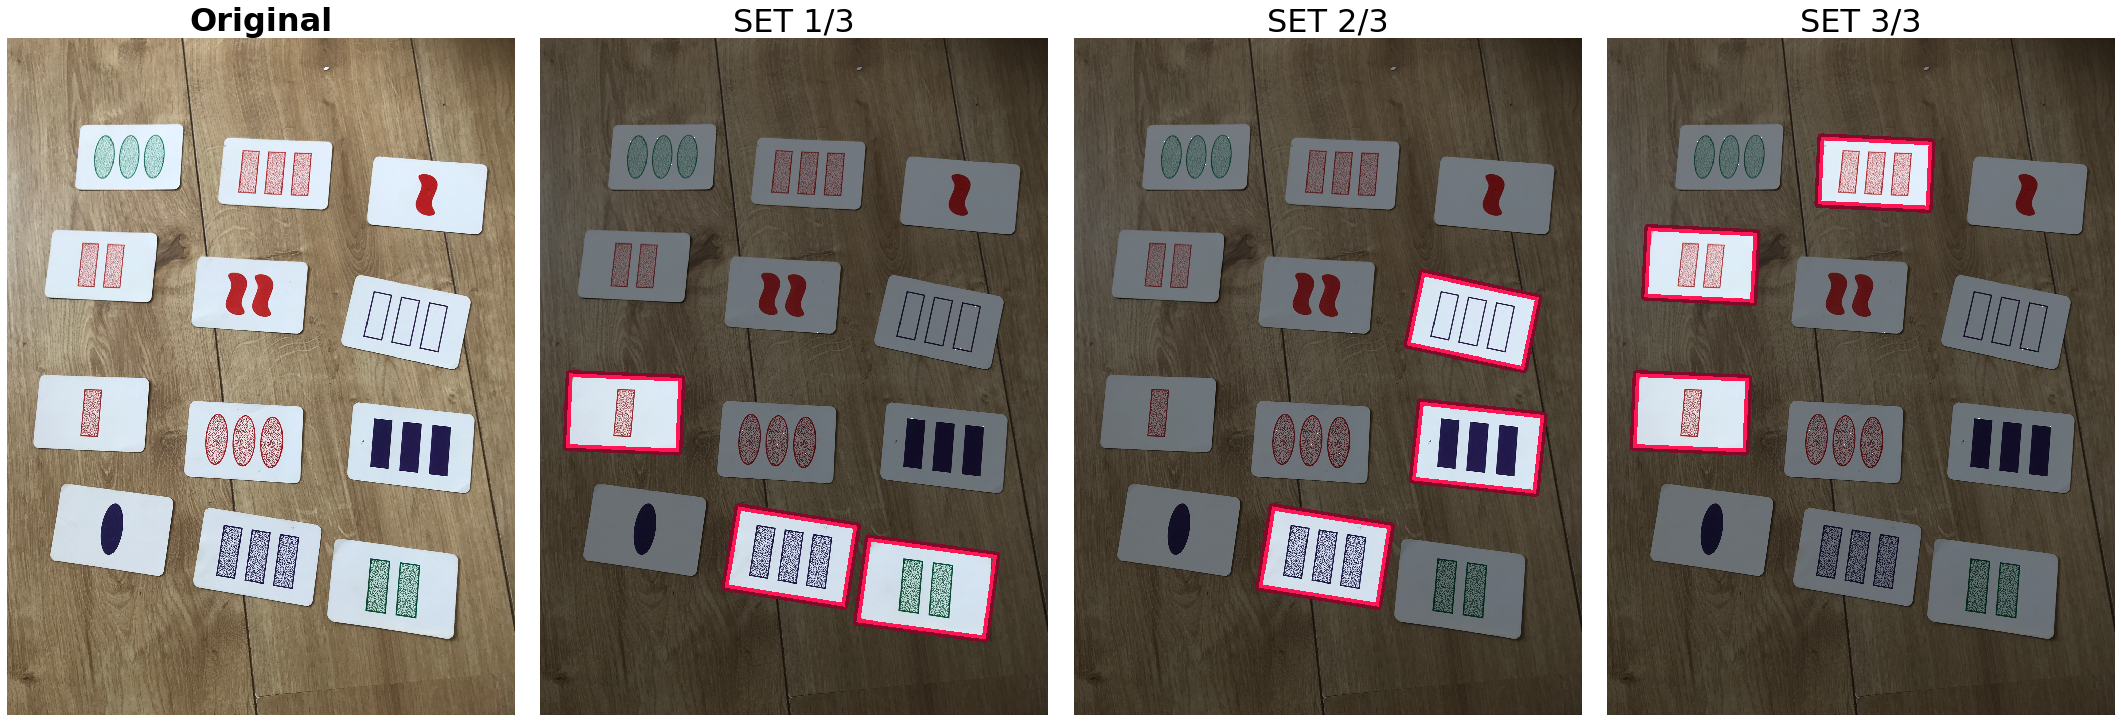

===
processing: IMG_6139.JPG
number of cards found: 12
nr sets found: 4
SET 1/4
- green squiggle solid two
- green square dotted two
- green round open two
SET 2/4
- purple square dotted three
- green round open two
- red squiggle solid one
SET 3/4
- purple square dotted three
- purple square solid three
- purple square open three
SET 4/4
- red round open two
- red squiggle solid one
- red square dotted three


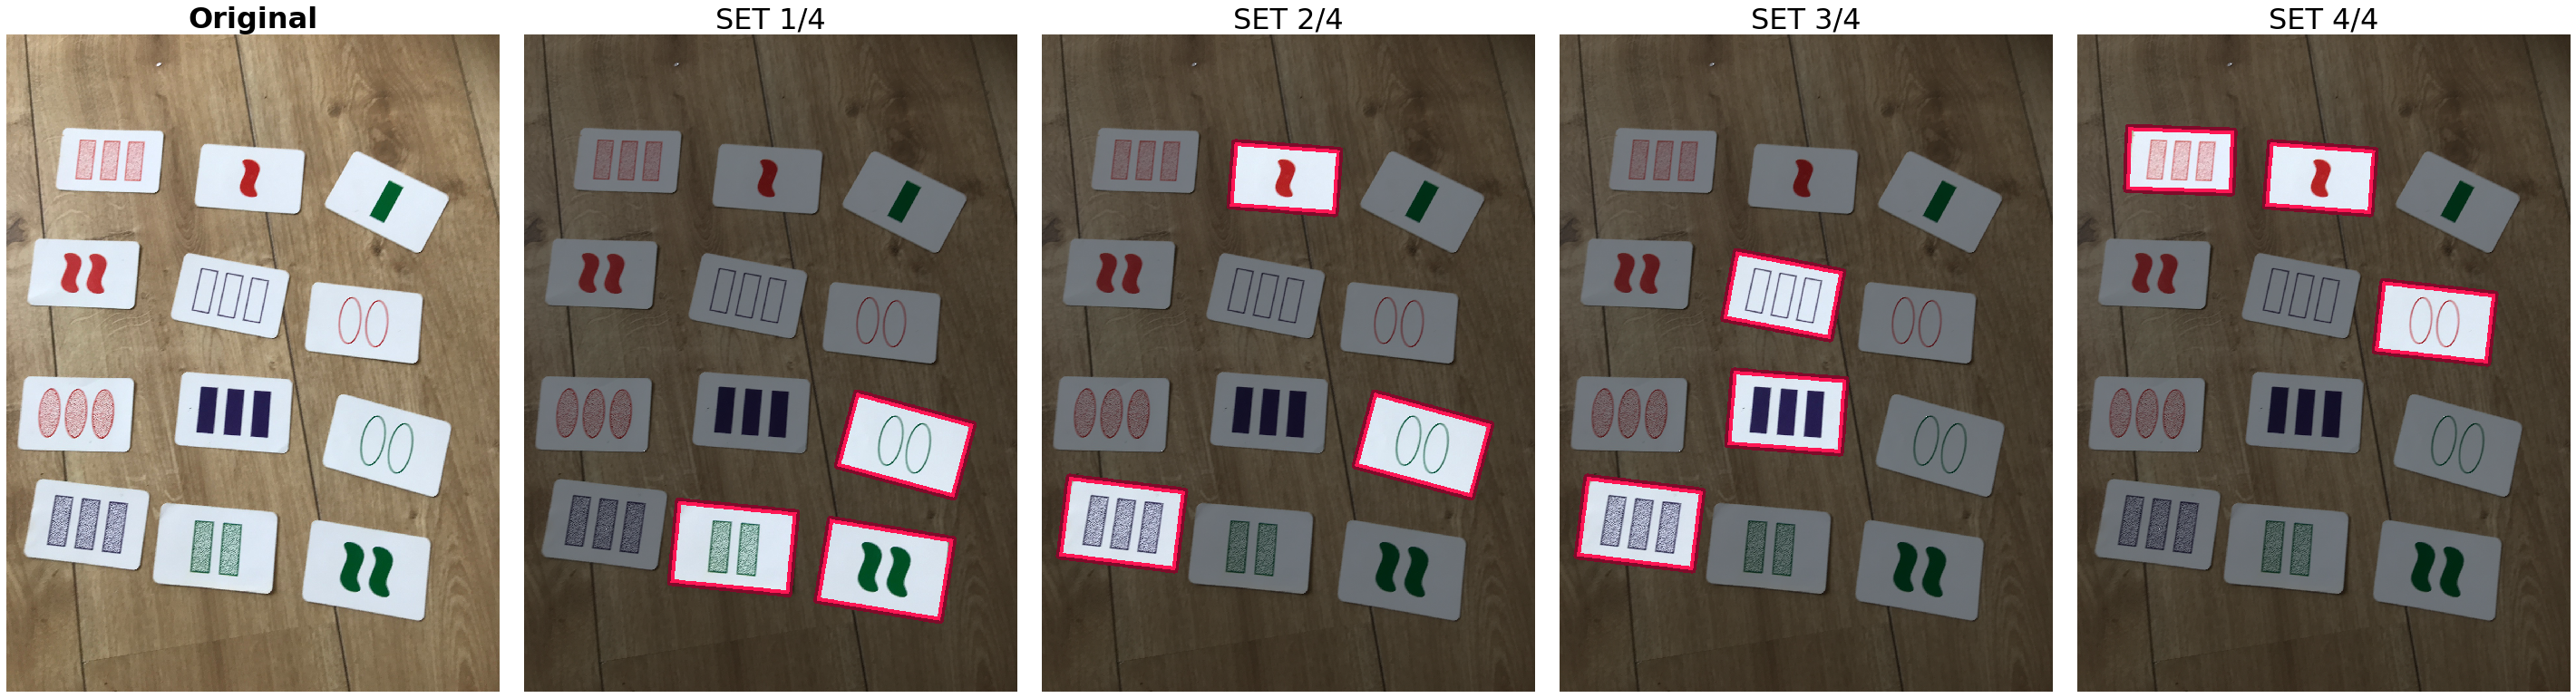

===
processing: IMG_6137.JPG
number of cards found: 12
nr sets found: 5
SET 1/5
- green square solid three
- purple square open three
- red square dotted three
SET 2/5
- purple square dotted three
- purple squiggle dotted one
- purple round dotted two
SET 3/5
- purple square dotted three
- purple square solid three
- purple square open three
SET 4/5
- purple squiggle dotted one
- red square dotted two
- green round dotted three
SET 5/5
- red square dotted one
- red square dotted two
- red square dotted three


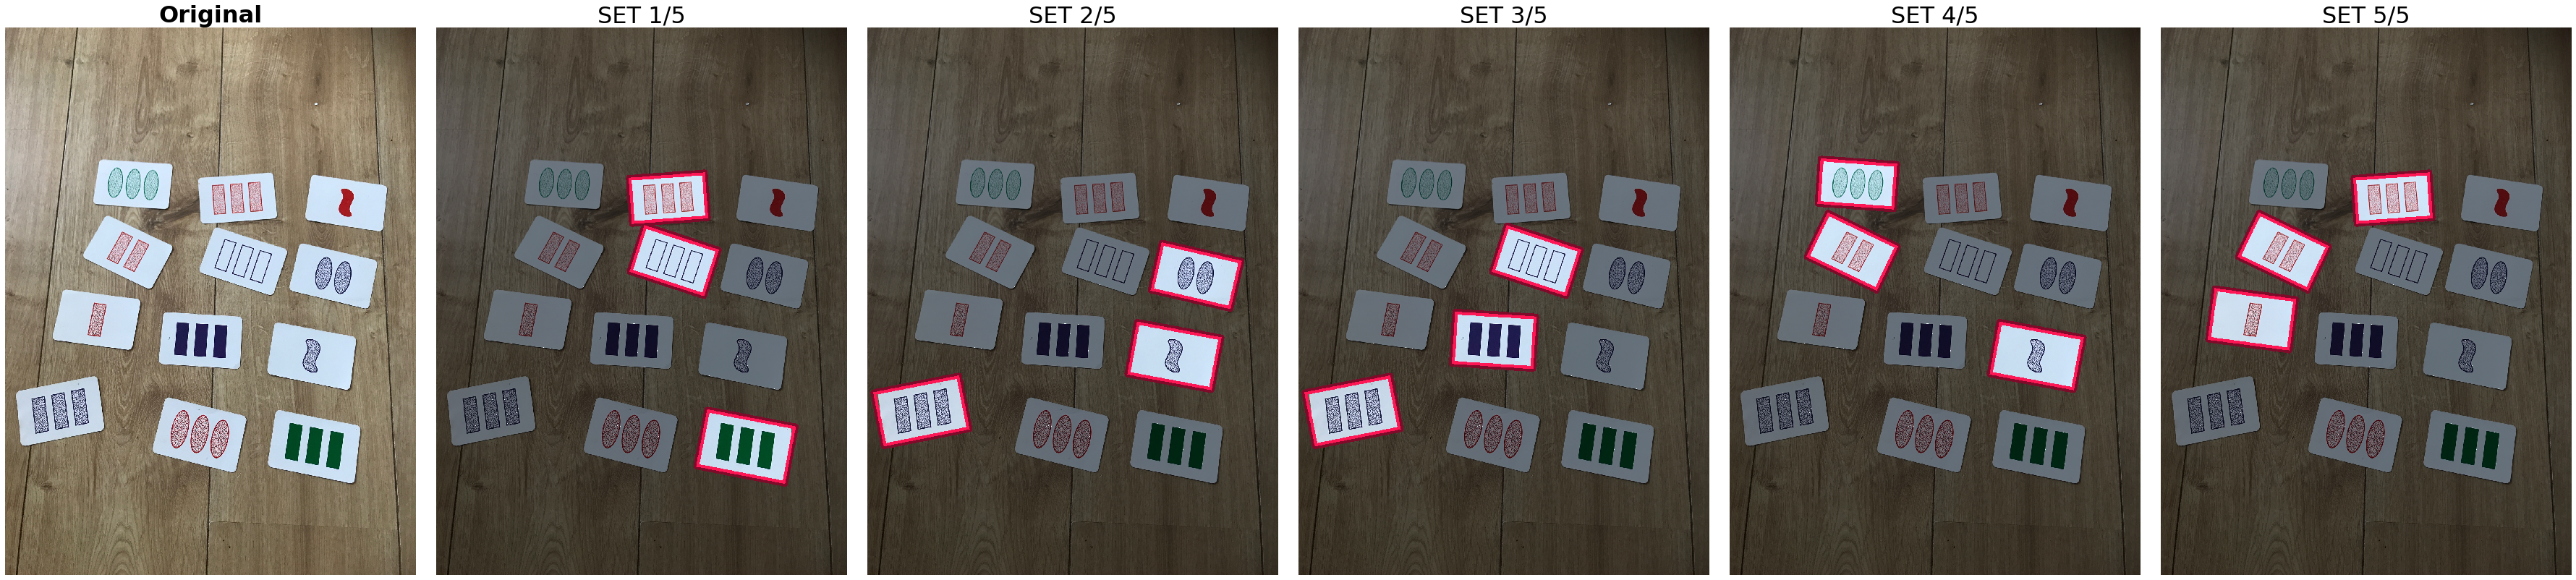

===
processing: IMG_6136.JPG
number of cards found: 12
nr sets found: 4
SET 1/4
- purple square solid three
- purple squiggle open one
- purple round dotted two
SET 2/4
- red square dotted one
- red square solid three
- red square open two
SET 3/4
- red square dotted one
- red square dotted three
- red square dotted two
SET 4/4
- purple squiggle solid one
- green round dotted three
- red square open two


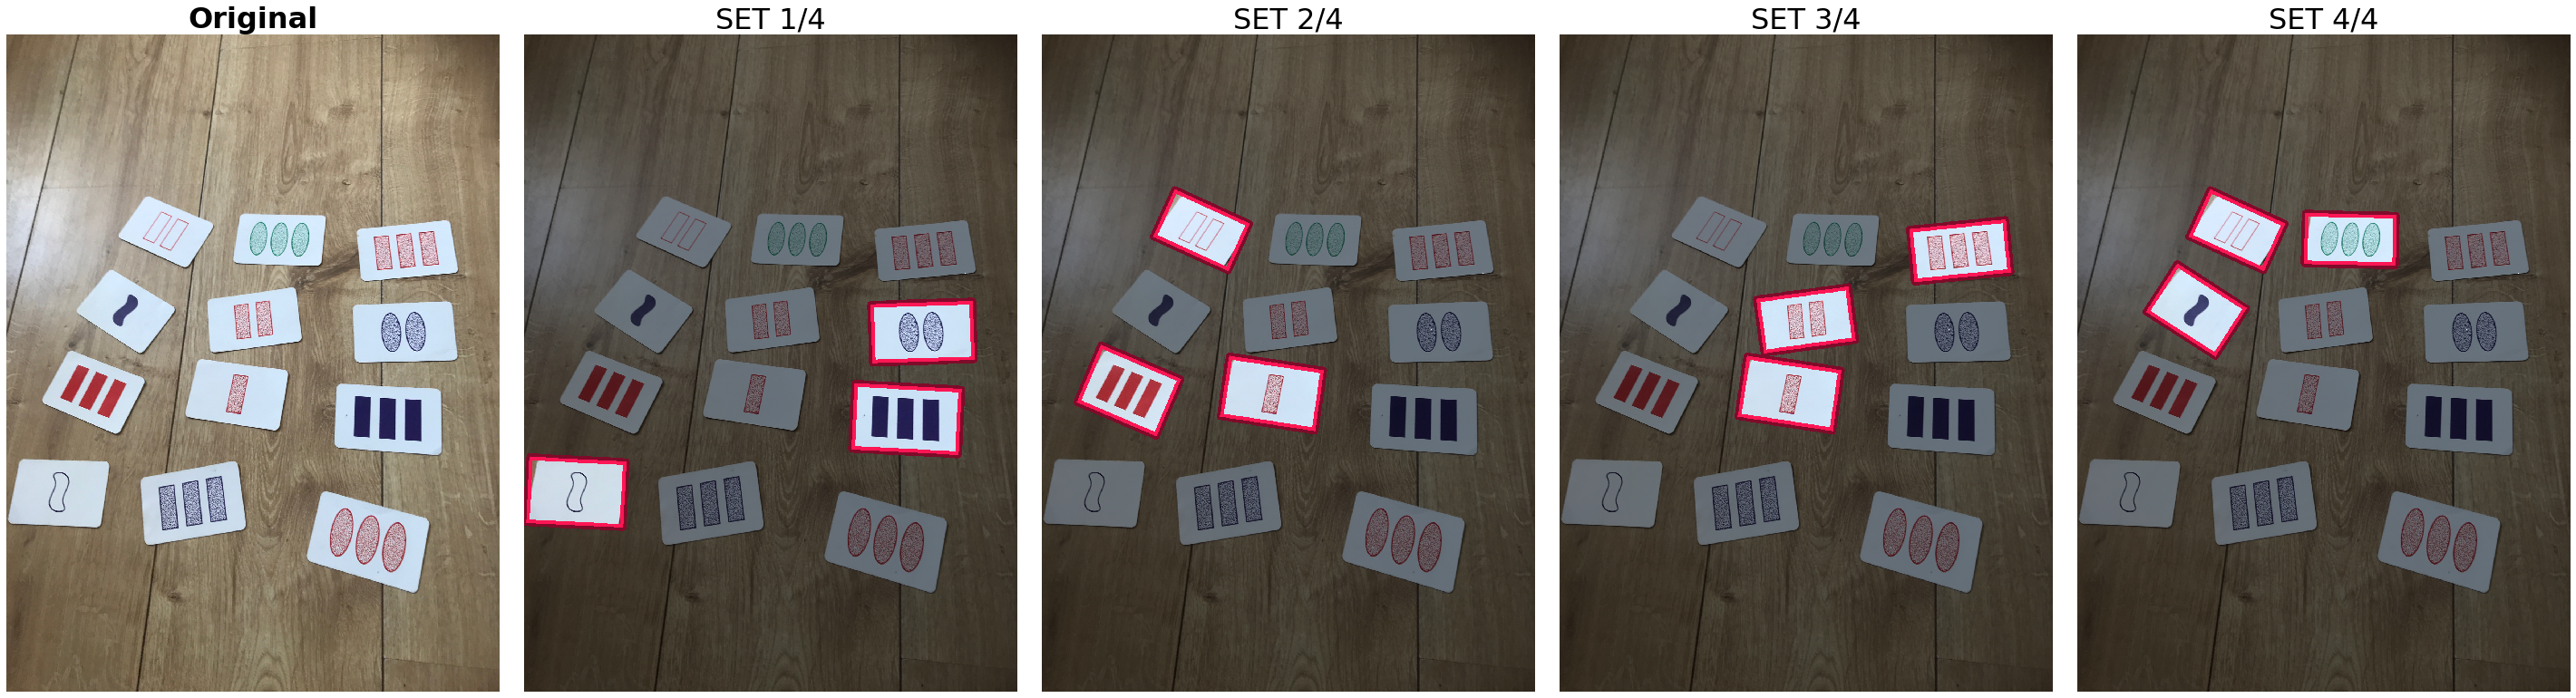

In [78]:
# putting it all together
test_images_path = project_path / "test_images"

# resize images to the input shape needed for the model
target_width, target_height = (128, 96)

# load meta data for the dataset (labels and features for each card type)
df_meta = load_metadata()

# loop throught all test images
for image_name in os.listdir(test_images_path):
    print(f"===")
    print(f"processing: {image_name}")
    
    # read image
    img = cv2.imread(str(test_images_path / image_name))
        
    # identify the different cards
    identified_images, bboxes = identify_images(img, target_size=(target_width, target_height))
    
    nr_found_cards = len(identified_images)
    print(f"number of cards found: {nr_found_cards}")
    
    # generate image embeddings for each card
    image_embeddings = intermediate_model.predict(identified_images).reshape(identified_images.shape[0], -1)
    
    # classify cards
    predictions = best_model.predict(image_embeddings)

    # get feature codes for each prediction
    predictions_features = get_feature_codes(df_meta, predictions)
    
    if len(predictions_features) != len(np.unique(predictions_features, axis=0)):
        print(f"found duplicate cards for {image_name}")
        continue
    
    # find all sets
    sets = findsets(predictions_features)
    
    # convert image to rgb for plotting
    img_rgb = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    
    # merge sets with the original image
    set_images = merge_sets_with_image(img_rgb, image_name, bboxes, sets, line_color=(255, 22, 84))
    
    # plot the merged images
    nr_sets_found = len(set_images)
    
    if nr_sets_found > 0:
        print(f"nr sets found: {nr_sets_found}")
        fig, axs = plt.subplots(nrows=1, ncols=nr_sets_found+1, figsize=(nr_sets_found*10, nr_sets_found*5))
        fig.tight_layout()

        # Make nice margins
        plt.subplots_adjust(wspace=0.05)

        # first image is the original
        axs[0].imshow(img_rgb)
        axs[0].set_title("Original", fontsize=32, fontweight="bold")
        axs[0].axis('off')

        # next images are found sets
        for i, set_image in enumerate(set_images):
            print(f"SET {i+1}/{nr_sets_found}")
            for card in sets[i]:
                img_label = get_card_data(df_meta, predictions[card])['label']
                print(f"- {img_label}")
            axs[i+1].set_title(f"SET {i+1}/{nr_sets_found}", fontsize=32)
            axs[i+1].imshow(set_image)
            axs[i+1].axis('off')

        # save and show images
        plt.savefig(output_path / f"found_sets_{image_name}.png", bbox_inches='tight')
        plt.show()
    else:
        print("no sets found")